In [74]:
"""
    ARIMA:
        Input:
        Historical price data P, order parameters (p, d, q), forecast horizon H. Output: Forecasted prices F
        1. Perform Augmented Dickey-Fuller test to check stationarity. 
        2. If data is non-stationary, apply differencing (d times) until stationary. 
        3. Select optimal (p, d, q) using AIC/BIC. 
        4. Fit ARIMA model with selected (p, d, q). 
        5. Forecast next H time steps. 
        6. Return forecasted prices F.
"""

'\n    ARIMA:\n        Input:\n        Historical price data P, order parameters (p, d, q), forecast horizon H. Output: Forecasted prices F\n        1. Perform Augmented Dickey-Fuller test to check stationarity. \n        2. If data is non-stationary, apply differencing (d times) until stationary. \n        3. Select optimal (p, d, q) using AIC/BIC. \n        4. Fit ARIMA model with selected (p, d, q). \n        5. Forecast next H time steps. \n        6. Return forecasted prices F.\n'

In [7]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, acf, pacf, kpss
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [8]:
print("====Load Data====")
final_dataset = pd.read_csv('../data/soybean_integrated_data_complete.csv', parse_dates=['Date'], index_col='Date')
final_dataset.asfreq('D')  # Ensure daily frequency

print(f"Dataset shape: {final_dataset.shape}")
print(f"Date range: {final_dataset.index.min()} to {final_dataset.index.max()}")
print(f"Total days: {len(final_dataset)}")

# Display data overview
print(f"\nData columns:")
for i, col in enumerate(final_dataset.columns, 1):
    print(f"  {i:2d}. {col}")

====Load Data====
Dataset shape: (1825, 15)
Date range: 2020-09-21 00:00:00 to 2025-09-19 00:00:00
Total days: 1825

Data columns:
   1. soybean_price
   2. usd_brl_rate
   3. rain_Paranagua_PR
   4. temp_Paranagua_PR
   5. rain_MatoGrosso_MT
   6. temp_MatoGrosso_MT
   7. rain_Goias_GO
   8. temp_Goias_GO
   9. rain_MatoGrossoSul_MS
  10. temp_MatoGrossoSul_MS
  11. rain_RioGrandeSul_RS
  12. temp_RioGrandeSul_RS
  13. brent_oil_close
  14. cbot_soybean_close
  15. wti_oil_close


In [4]:
final_dataset.head()

,soybean_price,usd_brl_rate,rain_Paranagua_PR,temp_Paranagua_PR,rain_MatoGrosso_MT,temp_MatoGrosso_MT,rain_Goias_GO,temp_Goias_GO,rain_MatoGrossoSul_MS,temp_MatoGrossoSul_MS,rain_RioGrandeSul_RS,temp_RioGrandeSul_RS,brent_oil_close,cbot_soybean_close,wti_oil_close
Date,,,,,,,,,,,,,,,
2020-09-21,26.75,5.4131,3.01,13.79,0.00,31.29,2.99,27.20,5.28,22.80,0.01,11.82,41.439999,1022.50,39.310001
2020-09-22,26.96,5.4704,0.21,14.31,0.01,30.28,1.95,24.71,1.98,23.14,0.01,11.52,41.720001,1019.75,39.599998
2020-09-23,26.87,5.5943,0.46,16.92,0.02,29.85,0.20,24.97,0.00,24.88,0.02,16.66,41.770000,1014.50,39.930000
2020-09-24,27.35,5.5089,0.12,19.52,0.08,31.26,0.00,27.31,0.00,26.70,0.01,20.56,41.939999,1000.00,40.310001
2020-09-25,26.45,5.5624,0.00,20.12,0.01,33.08,0.00,27.93,0.00,28.74,0.05,20.23,41.919998,1002.50,40.250000


In [29]:
# Define target variable and key exogenous variables
target_var = 'soybean_price'

# Select key exogenous variables
exog_vars = [
    'usd_brl_rate',           # USD/BRL exchange rate
    'cbot_soybean_close',     # CBOT soybean futures closing price
    'brent_oil_close',        # Brent oil price
    'wti_oil_close',          # WTI oil price
    # Major production regions weather data
    'rain_MatoGrosso_MT',     # Mato Grosso state rainfall
    'temp_MatoGrosso_MT',     # Mato Grosso state temperature
    'rain_RioGrandeSul_RS',   # Rio Grande do Sul state rainfall
    'temp_RioGrandeSul_RS',   # Rio Grande do Sul state temperature
    'rain_Paranagua_PR',      # Paranaguá port rainfall
    'temp_Paranagua_PR',      # Paranaguá port temperature
    'rain_Goias_GO',          # Goiás state rainfall
    'temp_Goias_GO',          # Goiás state temperature
    'rain_MatoGrossoSul_MS',  # Mato Grosso do Sul state rainfall
    'temp_MatoGrossoSul_MS'   # Mato Grosso do Sul state temperature
]

# Select key exogenous variables
selected_exog_vars = ['usd_brl_rate', 'cbot_soybean_close', 'brent_oil_close', 'wti_oil_close', 'temp_MatoGrosso_MT',
                      'temp_RioGrandeSul_RS', 'temp_Paranagua_PR',
                      'temp_Goias_GO', 'temp_MatoGrossoSul_MS']

selected_exog_vars_005 = ['cbot_soybean_close', 'brent_oil_close', 'wti_oil_close', 'usd_brl_rate', 'temp_MatoGrossoSul_MS', 'temp_Goias_GO', 'temp_MatoGrosso_MT', 'temp_Paranagua_PR', 'temp_RioGrandeSul_RS', 'rain_MatoGrossoSul_MS', 'rain_Paranagua_PR']

In [53]:
def check_stationarity(ts, title="Time Series", alpha=0.05):
    """
    Perform both ADF and KPSS stationarity tests for robust analysis
    """
    ts_clean = ts.dropna()
    print(f'\n=== {title} Enhanced Stationarity Test ===')
    
    # ADF Test (H0: non-stationary, H1: stationary)
    adf_result = adfuller(ts_clean)
    print(f'\n--- ADF Test Results ---')
    print(f'ADF Statistic: {adf_result[0]:.6f}')
    print(f'p-value: {adf_result[1]:.6f}')
    print(f'Critical Values:')
    for key, value in adf_result[4].items():
        print(f'\t{key}: {value:.3f}')
    
    adf_stationary = adf_result[1] <= alpha
    print(f'ADF Conclusion: The series {"is" if adf_stationary else "is not"} stationary (α={alpha})')
    
    # KPSS Test (H0: stationary, H1: non-stationary)
    try:
        # 抑制KPSS插值警告
        import warnings
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=UserWarning, message=".*interpolation.*")
            warnings.filterwarnings("ignore", message=".*range of p-values.*")
            kpss_result = kpss(ts_clean, regression='c', nlags='auto')
        
        print(f'\n--- KPSS Test Results ---')
        print(f'KPSS Statistic: {kpss_result[0]:.6f}')
        print(f'p-value: {kpss_result[1]:.6f}')
        if kpss_result[1] <= 0.01:
            print(f'Note: p-value may be smaller than reported (test statistic outside lookup table range)')
        print(f'Critical Values:')
        for key, value in kpss_result[3].items():
            print(f'\t{key}: {value:.3f}')
        
        kpss_stationary = kpss_result[1] > alpha  # Note: opposite interpretation
        print(f'KPSS Conclusion: The series {"is" if kpss_stationary else "is not"} stationary (α={alpha})')
        
        # Combined conclusion
        print(f'\n--- Combined Analysis ---')
        if adf_stationary and kpss_stationary:
            combined_result = True
            print("✓ Both tests agree: Series is STATIONARY")
        elif not adf_stationary and not kpss_stationary:
            combined_result = False
            print("✓ Both tests agree: Series is NON-STATIONARY")
        else:
            combined_result = False  # Conservative approach
            if adf_stationary and not kpss_stationary:
                print("Tests disagree: ADF suggests stationary, KPSS suggests non-stationary")
                print("  → Conservative decision: Treat as NON-STATIONARY")
            else:
                print("Tests disagree: ADF suggests non-stationary, KPSS suggests stationary")
                print("  → Conservative decision: Treat as NON-STATIONARY")
    
    except Exception as e:
        print(f'\n--- KPSS Test Failed ---')
        print(f'Error: {str(e)}')
        print('Using ADF test result only')
        combined_result = adf_stationary
    
    return combined_result

def determine_differencing_order(ts, max_d=3, alpha=0.05):
    """
    Determine the optimal differencing order (d) using enhanced stationarity tests
    """
    
    # Test original series
    original_ts = ts.copy()
    is_stationary = check_stationarity(original_ts, "Original Series", alpha)
    
    if is_stationary:
        print(f"Recommended differencing order: d = 0 (already stationary)")
        return 0, original_ts
    
    # Perform differencing until stationary or max_d reached
    current_ts = original_ts.copy()
    for d in range(1, max_d + 1):
        print(f"\n{'='*50}")
        print(f"Testing differencing order d = {d}")
        print(f"{'='*50}")
        
        current_ts = current_ts.diff().dropna()
        
        is_stationary = check_stationarity(current_ts, f"Differenced Series (d={d})", alpha)
        
        if is_stationary:
            print(f"Recommended differencing order: d = {d}")
            print(f"Final series has {len(current_ts)} observations")
            return d, current_ts
    
    # If still not stationary after max_d differences
    print(f"\nWarning: Series is still not stationary after {max_d} differences")
    print(f"Using d = {max_d} as maximum allowed")
    print(f"Final series has {len(current_ts)} observations")
    return max_d, current_ts

# Determine optimal differencing order using enhanced tests
print("Starting enhanced stationarity analysis...")
d, complete_data_processed = determine_differencing_order(final_dataset[target_var], max_d=3, alpha=0.05)


print(f"\n{'='*60}")
print(f"FINAL RESULTS")
print(f"{'='*60}")
print(f"Selected differencing order: d = {d}")
print(f"Original series length: {len(final_dataset[target_var])} observations")
if d > 0:
    print(f"Processed series length: {len(complete_data_processed)} observations")
    print(f"Lost {len(final_dataset[target_var]) - len(complete_data_processed)} observations due to differencing")
else:
    print(f"No differencing needed - using original series")

Starting enhanced stationarity analysis...

=== Original Series Enhanced Stationarity Test ===

--- ADF Test Results ---
ADF Statistic: -1.301971
p-value: 0.628270
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568
ADF Conclusion: The series is not stationary (α=0.05)

--- KPSS Test Results ---
KPSS Statistic: 3.924541
p-value: 0.010000
Note: p-value may be smaller than reported (test statistic outside lookup table range)
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
KPSS Conclusion: The series is not stationary (α=0.05)

--- Combined Analysis ---
✓ Both tests agree: Series is NON-STATIONARY

Testing differencing order d = 1

=== Differenced Series (d=1) Enhanced Stationarity Test ===

--- ADF Test Results ---
ADF Statistic: -23.698286
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568
ADF Conclusion: The series is stationary (α=0.05)

--- KPSS Test Results ---
KPSS Statistic: 0.197499
p-value: 0.100000
Critical Values:
	10%: 0.347
	5%: 0.463
	

In [35]:
# 通过观察AIC和BIC值确定p和q的范围
def find_optimal_arima_params(ts, max_p=3, max_q=3, d=1, ic='aic'):
    """
    使用网格搜索找到最优的ARIMA(p,d,q)参数
    """
    print(f"Grid search for optimal ARIMA parameters...")
    print(f"Parameter ranges: p=[0,{max_p}], d={d}, q=[0,{max_q}]")
    print(f"Information criterion: {ic.upper()}")
    
    # 确保时间序列有正确的频率
    if hasattr(ts, 'asfreq'):
        ts = ts.asfreq('D')
    
    results = []
    
    for p in range(max_p + 1):
        for q in range(max_q + 1):
            try:
                # 拟合ARIMA模型，使用基本参数
                model = ARIMA(ts, order=(p, d, q))
                
                # 使用简化的拟合方法
                import warnings
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    fitted_model = model.fit()
                
                # 获取信息准则值
                aic = fitted_model.aic
                bic = fitted_model.bic
                
                results.append({
                    'p': p, 'q': q, 
                    'AIC': aic, 'BIC': bic,
                    'params': (p, d, q),
                    'converged': True
                })
                
                print(f"ARIMA({p},{d},{q}) - AIC: {aic:.4f}, BIC: {bic:.4f} ✓")
                
            except Exception as e:
                error_msg = str(e)[:50]
                print(f"ARIMA({p},{d},{q}) - Error: {error_msg}... ✗")
                continue
    
    # 转换为DataFrame便于分析
    results_df = pd.DataFrame(results)
    
    if len(results_df) == 0:
        print("No valid models found!")
        return None, None
    
    print(f"\nFound {len(results_df)} valid models")
    
    # 根据选择的信息准则排序
    if ic.lower() == 'aic':
        best_model = results_df.loc[results_df['AIC'].idxmin()]
    else:
        best_model = results_df.loc[results_df['BIC'].idxmin()]
    
    print(f"\n{'='*50}")
    print(f"OPTIMAL MODEL SELECTION RESULTS")
    print(f"{'='*50}")
    print(f"Best model by {ic.upper()}: ARIMA{best_model['params']}")
    print(f"AIC: {best_model['AIC']:.4f}")
    print(f"BIC: {best_model['BIC']:.4f}")
    
    # 显示前5个最优模型
    print(f"\nTop 5 models by {ic.upper()}:")
    top_models = results_df.nsmallest(5, ic.upper())
    for idx, row in top_models.iterrows():
        print(f"ARIMA{row['params']} - AIC: {row['AIC']:.4f}, BIC: {row['BIC']:.4f}")
    
    return best_model['params'], results_df

In [10]:
# 使用确定的d值进行参数搜索
optimal_params, search_results = find_optimal_arima_params(
    final_dataset[target_var], 
    max_p=5, 
    max_q=5,  # 减少q的范围以避免过度拟合
    d=1,  # 使用之前确定的d值
    ic='aic'
)

NameError: name 'find_optimal_arima_params' is not defined

In [12]:
# best_p, best_d, best_q = optimal_params
best_p, best_d, best_q = (2, 1, 2)

In [13]:
train_size = int(len(final_dataset) * 0.8)
train_data = final_dataset.iloc[:train_size].copy()
test_data = final_dataset.iloc[train_size:].copy()

In [14]:
def arima_crossvalidation(model, train_df, h, step_size, test_df, order=None, target_var=target_var):
    """
    时间序列交叉验证函数

    参数:
    - model: 已训练的ARIMA模型或已拟合的结果对象
    - train_df: 训练数据 (DataFrame)
    - h: 预测步数
    - step_size: 每次向前移动的步数
    - test_df: 测试数据 (DataFrame)，索引为时间序列日期索引
    - order: ARIMA模型阶数 (p,d,q)

    返回:
    - 与 test_df 对齐的预测 Series（未预测的位置为 NaN）
    """
    # 存放最终预测结果（与 test_df 对齐）
    preds_series = pd.Series(index=test_df.index, dtype=float)

    n = len(test_df)
    print(f"Total test samples: {n}")

    # 计算需要进行多少次预测
    num_predictions = (n - h + step_size) // step_size + 1
    print(f"Number of prediction windows: {num_predictions}")

    for i in range(num_predictions):
        print(f"第{i+1}次预测")

        # 计算应该添加多少测试数据到训练集（用于扩展训练集）
        test_data_to_add = min(i * step_size, n)
        # 预测应该对应的 test_df 索引区间（从扩展后的训练集之后开始）
        start_idx = test_data_to_add
        end_idx = min(test_data_to_add + h, n)

        if start_idx >= end_idx:
            # 没有可预测的点
            continue

        # 获取对应的索引切片
        forecast_index = test_df.index[start_idx:end_idx]

        if i == 0:
            # 第一次预测：使用传入的模型（可能是已拟合结果或未拟合的 ARIMA 模型）
            try:
                forecast_vals = model.forecast(steps=h)
            except Exception:
                # 如果 model 是未拟合的 ARIMA 对象，先拟合
                try:
                    model_fit = model.fit()
                    forecast_vals = model_fit.forecast(steps=h)
                except Exception as e:
                    print(f"First-fold forecasting error: {e}")
                    forecast_vals = [0] * (end_idx - start_idx)
        else:
            # 扩展训练集并拟合新的模型
            extended_train = pd.concat([train_df, test_df.iloc[:test_data_to_add]])
            if order:
                cv_model = ARIMA(extended_train[target_var], order=order)
            else:
                cv_model = ARIMA(extended_train[target_var])

            try:
                model_fit = cv_model.fit()
                forecast_vals = model_fit.forecast(steps=h)
            except Exception as e:
                print(f"Error in fold {i+1}: {e}")
                # 使用上一次预测的最后一个值进行填充（若存在）或填充0
                last_val = None
                # 找到已有 preds_series 中最后一个非空值
                if preds_series.dropna().shape[0] > 0:
                    last_val = preds_series.dropna().iloc[-1]
                fill_len = end_idx - start_idx
                fill_val = last_val if last_val is not None else 0
                forecast_vals = [fill_val] * fill_len

        # 将预测截断为需要的长度（当 h 大于剩余点数时）
        forecast_list = list(forecast_vals)[: (end_idx - start_idx)]

        # 将预测写入与 test_df 对齐的 Series 中，后来的预测会覆盖之前的重叠部分
        for idx, val in zip(forecast_index, forecast_list):
            preds_series.loc[idx] = val

    print(f"Total predictions placed: {preds_series.notna().sum()}")
    return preds_series

In [15]:
def arimax_crossvalidation(model, train_df, h, step_size, test_df, order=None, target_var=None, exog_var=None):
    """
    时间序列交叉验证函数

    参数:
    - model: 已训练的ARIMA模型或已拟合的结果对象
    - train_df: 训练数据 (DataFrame)
    - h: 预测步数
    - step_size: 每次向前移动的步数
    - test_df: 测试数据 (DataFrame)，索引为时间序列日期索引
    - order: ARIMA模型阶数 (p,d,q)

    返回:
    - 与 test_df 对齐的预测 Series（未预测的位置为 NaN）
    """
    # 存放最终预测结果（与 test_df 对齐）
    preds_series = pd.Series(index=test_df.index, dtype=float)

    n = len(test_df)
    print(f"Total test samples: {n}")

    # 计算需要进行多少次预测
    num_predictions = (n - h + step_size) // step_size + 1
    print(f"Number of prediction windows: {num_predictions}")

    for i in range(num_predictions):
        print(f"第{i+1}次预测")

        # 计算应该添加多少测试数据到训练集（用于扩展训练集）
        test_data_to_add = min(i * step_size, n)
        # 预测应该对应的 test_df 索引区间（从扩展后的训练集之后开始）
        start_idx = test_data_to_add
        end_idx = min(test_data_to_add + h, n)

        if start_idx >= end_idx:
            # 没有可预测的点
            continue

        # 获取对应的索引切片
        forecast_index = test_df.index[start_idx:end_idx]

        if i == 0:
            # 第一次预测：使用传入的模型（可能是已拟合结果或未拟合的 ARIMA 模型）
            try:
                print(f'Predicting window size: {h}')
                forecast_vals = model.forecast(steps=h, exog=test_df[exog_var].iloc[:h])
            except Exception:
                # 如果 model 是未拟合的 ARIMA 对象，先拟合
                try:
                    model_fit = model.fit()
                    forecast_vals = model_fit.forecast(steps=h, exog=test_df[exog_var].iloc[:h])
                except Exception as e:
                    print(f"First-fold forecasting error: {e}")
                    forecast_vals = [0] * (end_idx - start_idx)
        else:
            # 扩展训练集并拟合新的模型
            extended_train = pd.concat([train_df, test_df.iloc[:test_data_to_add]])
            test_exog_features = test_df[exog_var].iloc[start_idx:end_idx]
            forecast_horizons = min(end_idx - start_idx, h)
            print(f'Predicting window size: {forecast_horizons}')
            if order:
                cv_model = ARIMA(extended_train[target_var], extended_train[exog_var], order=order)
            else:
                cv_model = ARIMA(extended_train[target_var], extended_train[exog_var])

            try:
                model_fit = cv_model.fit()
                forecast_vals = model_fit.forecast(steps=forecast_horizons, exog=test_exog_features)
            except Exception as e:
                print(f"Error in fold {i+1}: {e}")
                # 使用上一次预测的最后一个值进行填充（若存在）或填充0
                last_val = None
                # 找到已有 preds_series 中最后一个非空值
                if preds_series.dropna().shape[0] > 0:
                    last_val = preds_series.dropna().iloc[-1]
                fill_len = end_idx - start_idx
                fill_val = last_val if last_val is not None else 0
                forecast_vals = [fill_val] * fill_len

        # 将预测截断为需要的长度（当 h 大于剩余点数时）
        forecast_list = list(forecast_vals)[: (end_idx - start_idx)]

        # 将预测写入与 test_df 对齐的 Series 中，后来的预测会覆盖之前的重叠部分
        for idx, val in zip(forecast_index, forecast_list):
            preds_series.loc[idx] = val

    print(f"Total predictions placed: {preds_series.notna().sum()}")
    return preds_series

In [60]:
# 检查 plot_all 模块中可用的函数
from plot_all import prediction_plot, plot_error_bar_chart

In [16]:
arima_model_test = ARIMA(train_data[target_var], order=(best_p,best_d,best_q))
arima_model_test_fit = arima_model_test.fit()

In [17]:
arima_results_10 = arima_crossvalidation(arima_model_test, train_data, h=10, step_size=10, test_df=test_data, order=(best_p,best_d,best_q))

Total test samples: 365
Number of prediction windows: 37
第1次预测
第2次预测
第2次预测
第3次预测
第3次预测
第4次预测
第4次预测
第5次预测
第6次预测
第5次预测
第6次预测
第7次预测
第8次预测
第7次预测
第8次预测
第9次预测
第9次预测
第10次预测
第10次预测
第11次预测
第11次预测
第12次预测
第12次预测
第13次预测
第13次预测
第14次预测
第14次预测
第15次预测
第15次预测
第16次预测
第16次预测
第17次预测
第17次预测
第18次预测
第18次预测
第19次预测
第19次预测
第20次预测
第20次预测
第21次预测
第21次预测
第22次预测
第22次预测
第23次预测
第24次预测
第23次预测
第24次预测
第25次预测
第25次预测
第26次预测
第27次预测
第26次预测
第27次预测
第28次预测
第28次预测
第29次预测
第29次预测
第30次预测
第31次预测
第30次预测
第31次预测
第32次预测
第33次预测
第32次预测
第33次预测
第34次预测
第34次预测
第35次预测
第36次预测
第35次预测
第36次预测
第37次预测
Total predictions placed: 365
第37次预测
Total predictions placed: 365


In [27]:
print(len(target_var))

13


In [18]:
arimaX_results_10_selected = arimax_crossvalidation(arima_model_test, train_data, h=10, step_size=10, test_df=test_data, order=(2,1,2), target_var=target_var, exog_var=selected_exog_vars)

Total test samples: 365
Number of prediction windows: 37
第1次预测
Predicting window size: 10
第2次预测
Predicting window size: 10
第2次预测
Predicting window size: 10
第3次预测
Predicting window size: 10
第3次预测
Predicting window size: 10
第4次预测
Predicting window size: 10
第4次预测
Predicting window size: 10
第5次预测
Predicting window size: 10
第5次预测
Predicting window size: 10
第6次预测
Predicting window size: 10
第6次预测
Predicting window size: 10
第7次预测
Predicting window size: 10
第7次预测
Predicting window size: 10
第8次预测
Predicting window size: 10
第8次预测
Predicting window size: 10
第9次预测
Predicting window size: 10
第9次预测
Predicting window size: 10
第10次预测
Predicting window size: 10
第10次预测
Predicting window size: 10
第11次预测
Predicting window size: 10
第11次预测
Predicting window size: 10
第12次预测
Predicting window size: 10
第12次预测
Predicting window size: 10
第13次预测
Predicting window size: 10
第13次预测
Predicting window size: 10
第14次预测
Predicting window size: 10
第14次预测
Predicting window size: 10
第15次预测
Predicting window size: 10
第15次预测
P

In [19]:
arimaX_results_10_all = arimax_crossvalidation(arima_model_test, train_data, h=10, step_size=10, test_df=test_data, order=(2,1,2), target_var=target_var, exog_var=exog_vars)

Total test samples: 365
Number of prediction windows: 37
第1次预测
Predicting window size: 10
第2次预测
Predicting window size: 10
第3次预测
Predicting window size: 10
第3次预测
Predicting window size: 10
第4次预测
Predicting window size: 10
第4次预测
Predicting window size: 10
第5次预测
Predicting window size: 10
第5次预测
Predicting window size: 10
第6次预测
Predicting window size: 10
第6次预测
Predicting window size: 10
第7次预测
Predicting window size: 10
第7次预测
Predicting window size: 10
第8次预测
Predicting window size: 10
第8次预测
Predicting window size: 10
第9次预测
Predicting window size: 10
第9次预测
Predicting window size: 10
第10次预测
Predicting window size: 10
第10次预测
Predicting window size: 10
第11次预测
Predicting window size: 10
第11次预测
Predicting window size: 10
第12次预测
Predicting window size: 10
第12次预测
Predicting window size: 10
第13次预测
Predicting window size: 10
第13次预测
Predicting window size: 10
第14次预测
Predicting window size: 10
第14次预测
Predicting window size: 10
第15次预测
Predicting window size: 10
第15次预测
Predicting window size: 10
第16次预测


In [30]:
arimaX_results_10_005 = arimax_crossvalidation(arima_model_test, train_data, h=10, step_size=10, test_df=test_data, order=(2,1,2), target_var=target_var, exog_var=selected_exog_vars_005)

Total test samples: 365
Number of prediction windows: 37
第1次预测
Predicting window size: 10
第2次预测
Predicting window size: 10
第2次预测
Predicting window size: 10
第3次预测
Predicting window size: 10
第3次预测
Predicting window size: 10
第4次预测
Predicting window size: 10
第4次预测
Predicting window size: 10
第5次预测
Predicting window size: 10
第5次预测
Predicting window size: 10
第6次预测
Predicting window size: 10
第6次预测
Predicting window size: 10
第7次预测
Predicting window size: 10
第7次预测
Predicting window size: 10
第8次预测
Predicting window size: 10
第8次预测
Predicting window size: 10
第9次预测
Predicting window size: 10
第9次预测
Predicting window size: 10
第10次预测
Predicting window size: 10
第10次预测
Predicting window size: 10
第11次预测
Predicting window size: 10
第11次预测
Predicting window size: 10
第12次预测
Predicting window size: 10
第12次预测
Predicting window size: 10
第13次预测
Predicting window size: 10
第13次预测
Predicting window size: 10
第14次预测
Predicting window size: 10
第14次预测
Predicting window size: 10
第15次预测
Predicting window size: 10
第15次预测
P

In [31]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

results = {}
modes = [
    ('NONE', [target_var]),
    ('SELECTED', [target_var] + selected_exog_vars),
    ('ALL', [target_var] + exog_vars),
    ('005', [target_var] + selected_exog_vars_005)
]
for name, cols in modes:
    if name == 'NONE':
        results[name] = arima_results_10
    elif name == 'SELECTED':
        results[name] = arimaX_results_10_selected
    elif name == '005':
        results[name] = arimaX_results_10_005
    else:
        results[name] = arimaX_results_10_all

preds_plot = {k: v[:len(test_data)] for k, v in results.items()}

# 计算指标
metrics_mae = {}
metrics_mse = {}
for name, pred in preds_plot.items():
    mae = mean_absolute_error(test_data[target_var], pred)
    mse = mean_squared_error(test_data[target_var], pred)
    metrics_mae[name] = f"MAE: {mae:.2f}"
    metrics_mse[name] = f", MSE: {mse:.2f}"

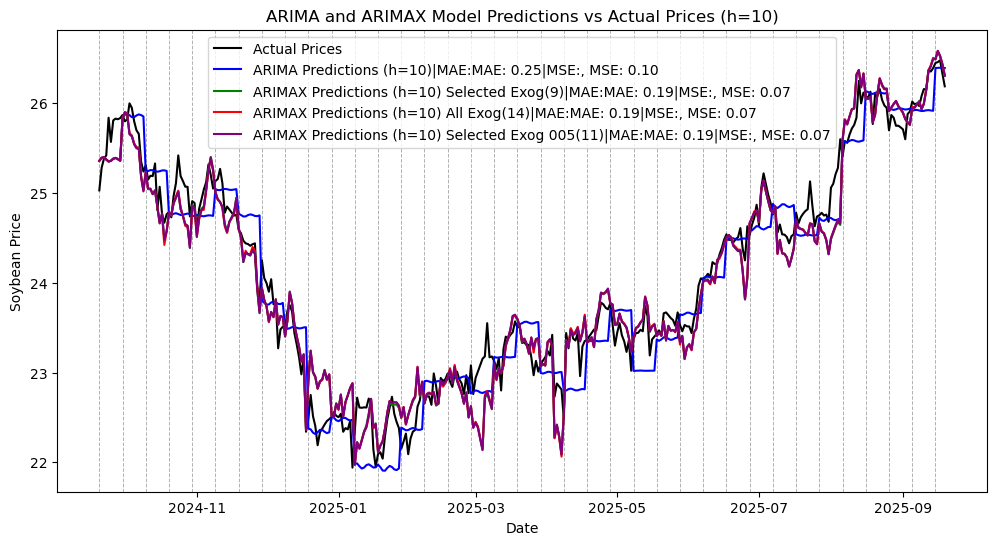

In [32]:

plt.figure(figsize=(12,6))
# 每10天添加竖直虚线
ax = plt.gca()
for v in pd.date_range(start=test_data[target_var].index.min(), end=test_data[target_var].index.max(), freq='10D'):
    ax.axvline(v, color='gray', linestyle='--', linewidth=0.7, alpha=0.6)
plt.plot(test_data[target_var], label='Actual Prices', color='black')
plt.plot(arima_results_10, label=f'ARIMA Predictions (h=10)|MAE:{metrics_mae["NONE"]}|MSE:{metrics_mse["NONE"]}', color='blue')
plt.plot(arimaX_results_10_selected, label=f'ARIMAX Predictions (h=10) Selected Exog({len(selected_exog_vars)})|MAE:{metrics_mae["SELECTED"]}|MSE:{metrics_mse["SELECTED"]}', color='green')
plt.plot(arimaX_results_10_all, label=f'ARIMAX Predictions (h=10) All Exog({len(exog_vars)})|MAE:{metrics_mae["ALL"]}|MSE:{metrics_mse["ALL"]}', color='red')
plt.plot(arimaX_results_10_005, label=f'ARIMAX Predictions (h=10) Selected Exog 005({len(selected_exog_vars_005)})|MAE:{metrics_mae["005"]}|MSE:{metrics_mse["005"]}', color='purple')
plt.title('ARIMA and ARIMAX Model Predictions vs Actual Prices (h=10)')
plt.xlabel('Date')
plt.ylabel('Soybean Price')
plt.legend()
plt.show()

In [68]:
import pywt  # 引入小波变换库

# 1. 定义小波去噪函数 (The "WT" part)
def wavelet_denoising(data, wavelet='db4', level=2):
    """
    修正版：增加长度检查，确保去噪后的数据长度与原始输入完全一致。
    """
    # 1. 记录原始长度
    original_len = len(data)
    
    # 2. 分解
    coeff = pywt.wavedec(data, wavelet, mode="per", level=level)
    
    # 3. 计算阈值 (通用阈值)
    sigma = (1/0.6745) * np.nanmedian(np.abs(coeff[-1] - np.nanmedian(coeff[-1])))
    uthesh = sigma * np.sqrt(2 * np.log(len(data)))
    
    # 4. 阈值处理 (Soft Thresholding)
    # 对所有细节系数(detail coefficients)进行去噪
    coeff[1:] = (pywt.threshold(i, value=uthesh, mode='soft') for i in coeff[1:])
    
    # 5. 重构
    recon_data = pywt.waverec(coeff, wavelet, mode='per')
    
    # --- 【关键修复】 长度对齐 ---
    if len(recon_data) > original_len:
        # 如果变长了，直接截断后面多余的部分
        recon_data = recon_data[:original_len]
    elif len(recon_data) < original_len:
        # 如果变短了（极少见），用最后一个值填充
        recon_data = np.pad(recon_data, (0, original_len - len(recon_data)), 'edge')
    
    recon_data = np.round(recon_data, 4)

    return recon_data

In [69]:
dn_data = wavelet_denoising(final_dataset[target_var])  # 对原始数据进行去噪
dn_data_series = pd.Series(dn_data, index=final_dataset.index)  # 转换为 Series 并保持索引一致
dn_all_dataset = final_dataset.copy()
dn_all_dataset[target_var] = dn_data_series  # 替换为去噪数据

In [70]:
dn_all_dataset.head()

,soybean_price,usd_brl_rate,rain_Paranagua_PR,temp_Paranagua_PR,rain_MatoGrosso_MT,temp_MatoGrosso_MT,rain_Goias_GO,temp_Goias_GO,rain_MatoGrossoSul_MS,temp_MatoGrossoSul_MS,rain_RioGrandeSul_RS,temp_RioGrandeSul_RS,brent_oil_close,cbot_soybean_close,wti_oil_close
Date,,,,,,,,,,,,,,,
2020-09-21,26.5164,5.4131,3.01,13.79,0.00,31.29,2.99,27.20,5.28,22.80,0.01,11.82,41.439999,1022.50,39.310001
2020-09-22,26.6979,5.4704,0.21,14.31,0.01,30.28,1.95,24.71,1.98,23.14,0.01,11.52,41.720001,1019.75,39.599998
2020-09-23,26.9562,5.5943,0.46,16.92,0.02,29.85,0.20,24.97,0.00,24.88,0.02,16.66,41.770000,1014.50,39.930000
2020-09-24,27.0315,5.5089,0.12,19.52,0.08,31.26,0.00,27.31,0.00,26.70,0.01,20.56,41.939999,1000.00,40.310001
2020-09-25,26.8982,5.5624,0.00,20.12,0.01,33.08,0.00,27.93,0.00,28.74,0.05,20.23,41.919998,1002.50,40.250000


In [53]:
train_data_dn = dn_all_dataset.iloc[:train_size].copy()
test_data_dn = dn_all_dataset.iloc[train_size:].copy()

In [38]:
optimal_params_dn, _ = find_optimal_arima_params(
    pd.Series(dn_data, index=final_dataset.index), 
    max_p=5, 
    max_q=5,  # 减少q的范围以避免过度拟合
    d=1,  # 使用之前确定的d值
    ic='aic'
)

Grid search for optimal ARIMA parameters...
Parameter ranges: p=[0,5], d=1, q=[0,5]
Information criterion: AIC
ARIMA(0,1,0) - AIC: -1425.1668, BIC: -1419.6580 ✓
ARIMA(0,1,1) - AIC: -2832.7740, BIC: -2821.7565 ✓
ARIMA(0,1,2) - AIC: -3070.1219, BIC: -3053.5955 ✓
ARIMA(0,1,2) - AIC: -3070.1219, BIC: -3053.5955 ✓
ARIMA(0,1,3) - AIC: -3153.5995, BIC: -3131.5643 ✓
ARIMA(0,1,3) - AIC: -3153.5995, BIC: -3131.5643 ✓
ARIMA(0,1,4) - AIC: -3179.0652, BIC: -3151.5213 ✓
ARIMA(0,1,4) - AIC: -3179.0652, BIC: -3151.5213 ✓
ARIMA(0,1,5) - AIC: -3191.4596, BIC: -3158.4069 ✓
ARIMA(1,1,0) - AIC: -2866.8174, BIC: -2855.7999 ✓
ARIMA(1,1,1) - AIC: -3171.5149, BIC: -3154.9886 ✓
ARIMA(0,1,5) - AIC: -3191.4596, BIC: -3158.4069 ✓
ARIMA(1,1,0) - AIC: -2866.8174, BIC: -2855.7999 ✓
ARIMA(1,1,1) - AIC: -3171.5149, BIC: -3154.9886 ✓
ARIMA(1,1,2) - AIC: -3172.5555, BIC: -3150.5203 ✓
ARIMA(1,1,2) - AIC: -3172.5555, BIC: -3150.5203 ✓
ARIMA(1,1,3) - AIC: -3179.8491, BIC: -3152.3051 ✓
ARIMA(1,1,3) - AIC: -3179.8491, BIC: -3

In [42]:
best_params_dn = optimal_params_dn
print(f"Optimal parameters for denoised data: p={best_params_dn[0]}, d={best_params_dn[1]}, q={best_params_dn[2]}")

Optimal parameters for denoised data: p=3, d=1, q=5


In [54]:
arima_results_10_dn = arima_crossvalidation(arima_model_test, train_data_dn, h=10, step_size=10, test_df=test_data_dn, order=(best_params_dn[0],best_params_dn[1],best_params_dn[2]))

Total test samples: 365
Number of prediction windows: 37
第1次预测
第2次预测
第3次预测
第3次预测
第4次预测
第4次预测
第5次预测
第5次预测
第6次预测
第6次预测
第7次预测
第7次预测
第8次预测
第8次预测
第9次预测
第9次预测
第10次预测
第10次预测
第11次预测
第11次预测
第12次预测
第12次预测
第13次预测
第13次预测
第14次预测
第14次预测
第15次预测
第15次预测
第16次预测
第16次预测
第17次预测
第17次预测
第18次预测
第18次预测
第19次预测
第19次预测
第20次预测
第20次预测
第21次预测
第21次预测
第22次预测
第22次预测
第23次预测
第23次预测
第24次预测
第24次预测
第25次预测
第25次预测
第26次预测
第26次预测
第27次预测
第27次预测
第28次预测
第28次预测
第29次预测
第29次预测
第30次预测
第30次预测
第31次预测
第31次预测
第32次预测
第32次预测
第33次预测
第33次预测
第34次预测
第34次预测
第35次预测
第35次预测
第36次预测
第36次预测
第37次预测
第37次预测
Total predictions placed: 365
Total predictions placed: 365


In [59]:
arimaX_results_10_dn_selected = arimax_crossvalidation(arima_model_test, train_data_dn, h=10, step_size=10, test_df=test_data_dn, order=(best_params_dn[0],best_params_dn[1],best_params_dn[2]), target_var=target_var, exog_var=selected_exog_vars)

Total test samples: 365
Number of prediction windows: 37
第1次预测
Predicting window size: 10
第2次预测
Predicting window size: 10
第2次预测
Predicting window size: 10
第3次预测
Predicting window size: 10
第3次预测
Predicting window size: 10
第4次预测
Predicting window size: 10
第4次预测
Predicting window size: 10
第5次预测
Predicting window size: 10
第5次预测
Predicting window size: 10
第6次预测
Predicting window size: 10
第6次预测
Predicting window size: 10
第7次预测
Predicting window size: 10
第7次预测
Predicting window size: 10
第8次预测
Predicting window size: 10
第8次预测
Predicting window size: 10
第9次预测
Predicting window size: 10
第9次预测
Predicting window size: 10
第10次预测
Predicting window size: 10
第10次预测
Predicting window size: 10
第11次预测
Predicting window size: 10
第11次预测
Predicting window size: 10
第12次预测
Predicting window size: 10
第12次预测
Predicting window size: 10
第13次预测
Predicting window size: 10
第13次预测
Predicting window size: 10
第14次预测
Predicting window size: 10
第14次预测
Predicting window size: 10
第15次预测
Predicting window size: 10
第15次预测
P

In [60]:
arimaX_results_10_all_dn = arimax_crossvalidation(arima_model_test, train_data_dn, h=10, step_size=10, test_df=test_data_dn, order=(best_params_dn[0],best_params_dn[1],best_params_dn[2]), target_var=target_var, exog_var=exog_vars)

Total test samples: 365
Number of prediction windows: 37
第1次预测
Predicting window size: 10
第2次预测
Predicting window size: 10
第2次预测
Predicting window size: 10
第3次预测
Predicting window size: 10
第3次预测
Predicting window size: 10
第4次预测
Predicting window size: 10
第4次预测
Predicting window size: 10
第5次预测
Predicting window size: 10
第5次预测
Predicting window size: 10
第6次预测
Predicting window size: 10
第6次预测
Predicting window size: 10
第7次预测
Predicting window size: 10
第7次预测
Predicting window size: 10
第8次预测
Predicting window size: 10
第8次预测
Predicting window size: 10
第9次预测
Predicting window size: 10
第9次预测
Predicting window size: 10
第10次预测
Predicting window size: 10
第10次预测
Predicting window size: 10
第11次预测
Predicting window size: 10
第11次预测
Predicting window size: 10
第12次预测
Predicting window size: 10
第12次预测
Predicting window size: 10
第13次预测
Predicting window size: 10
第13次预测
Predicting window size: 10
第14次预测
Predicting window size: 10
第14次预测
Predicting window size: 10
第15次预测
Predicting window size: 10
第15次预测
P

In [61]:
arimaX_results_005_dn = arimax_crossvalidation(arima_model_test, train_data_dn, h=10, step_size=10, test_df=test_data_dn, order=(best_params_dn[0],best_params_dn[1],best_params_dn[2]), target_var=target_var, exog_var=selected_exog_vars_005)

Total test samples: 365
Number of prediction windows: 37
第1次预测
Predicting window size: 10
第2次预测
Predicting window size: 10
第3次预测
Predicting window size: 10
第3次预测
Predicting window size: 10
第4次预测
Predicting window size: 10
第4次预测
Predicting window size: 10
第5次预测
Predicting window size: 10
第5次预测
Predicting window size: 10
第6次预测
Predicting window size: 10
第6次预测
Predicting window size: 10
第7次预测
Predicting window size: 10
第7次预测
Predicting window size: 10
第8次预测
Predicting window size: 10
第8次预测
Predicting window size: 10
第9次预测
Predicting window size: 10
第9次预测
Predicting window size: 10
第10次预测
Predicting window size: 10
第10次预测
Predicting window size: 10
第11次预测
Predicting window size: 10
第11次预测
Predicting window size: 10
第12次预测
Predicting window size: 10
第12次预测
Predicting window size: 10
第13次预测
Predicting window size: 10
第13次预测
Predicting window size: 10
第14次预测
Predicting window size: 10
第14次预测
Predicting window size: 10
第15次预测
Predicting window size: 10
第15次预测
Predicting window size: 10
第16次预测


In [62]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

results_dn = {}
modes = [
    ('NONE', [target_var]),
    ('SELECTED', [target_var] + selected_exog_vars),
    ('ALL', [target_var] + exog_vars),
    ('005', [target_var] + selected_exog_vars_005)
]
for name, cols in modes:
    if name == 'NONE':
        results_dn[name] = arima_results_10
    elif name == 'SELECTED':
        results_dn[name] = arimaX_results_10_selected
    elif name == '005':
        results_dn[name] = arimaX_results_10_005
    else:
        results_dn[name] = arimaX_results_10_all
preds_plot_dn = {k: v[:len(test_data)] for k, v in results_dn.items()}

# 计算指标
metrics_dn_mae = {}
metrics_dn_mse = {}
for name, pred in preds_plot_dn.items():
    mae = mean_absolute_error(test_data_dn[target_var], pred)
    mse = mean_squared_error(test_data_dn[target_var], pred)
    metrics_dn_mae[name] = f"MAE: {mae:.2f}"
    metrics_dn_mse[name] = f", MSE: {mse:.2f}"

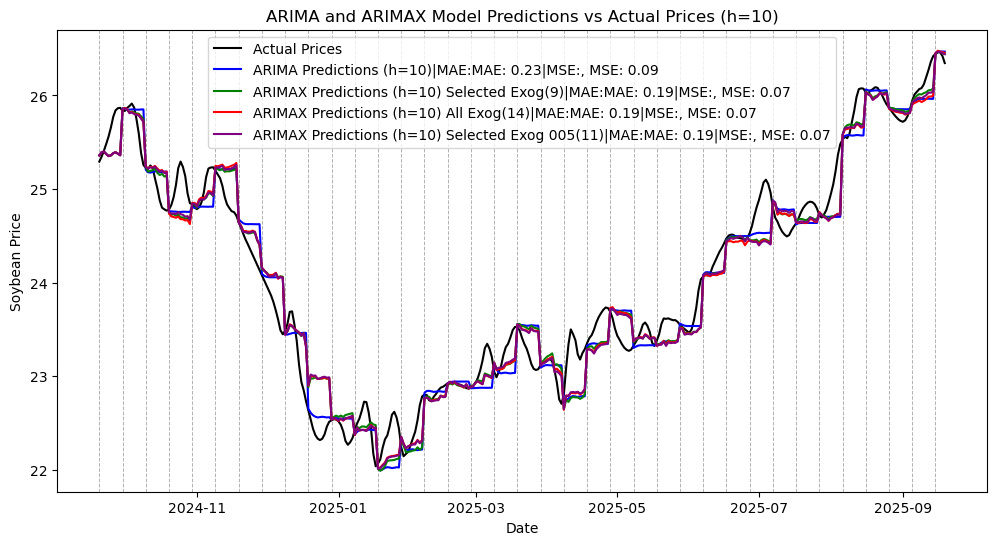

In [63]:
plt.figure(figsize=(12,6))
# 每10天添加竖直虚线
ax = plt.gca()
for v in pd.date_range(start=test_data_dn[target_var].index.min(), end=test_data_dn[target_var].index.max(), freq='10D'):
    ax.axvline(v, color='gray', linestyle='--', linewidth=0.7, alpha=0.6)
plt.plot(test_data_dn[target_var], label='Actual Prices', color='black')
plt.plot(arima_results_10_dn, label=f'ARIMA Predictions (h=10)|MAE:{metrics_dn_mae["NONE"]}|MSE:{metrics_dn_mse["NONE"]}', color='blue')
plt.plot(arimaX_results_10_dn_selected, label=f'ARIMAX Predictions (h=10) Selected Exog({len(selected_exog_vars)})|MAE:{metrics_dn_mae["SELECTED"]}|MSE:{metrics_dn_mse["SELECTED"]}', color='green')
plt.plot(arimaX_results_10_all_dn, label=f'ARIMAX Predictions (h=10) All Exog({len(exog_vars)})|MAE:{metrics_dn_mae["ALL"]}|MSE:{metrics_dn_mse["ALL"]}', color='red')
plt.plot(arimaX_results_005_dn, label=f'ARIMAX Predictions (h=10) Selected Exog 005({len(selected_exog_vars_005)})|MAE:{metrics_mae["005"]}|MSE:{metrics_mse["005"]}', color='purple')
plt.title('ARIMA and ARIMAX Model Predictions vs Actual Prices (h=10)')
plt.xlabel('Date')
plt.ylabel('Soybean Price')
plt.legend()
plt.show()